In [127]:
#!/usr/bin/env python
import sys
import os
import glob
import re
import ast
import betterast
import pandas as pd
sys.path.insert(0, os.path.abspath('../featurization'))
sys.path.insert(0, os.path.abspath('featurization'))
from individual_features import abc_score
from matplotlib import pyplot as plt
%matplotlib inline

def get_node_label(node):
    '''
    Get the label of a python ast object.
    '''
    return str(type(node)).replace("<class '_ast.","").replace("'>","")

def build_tree(node, ast_node, functions):
    '''
    Recursively construct a Node object out of a python ast object.
    '''
    if isinstance(ast_node, str) or isinstance(ast_node, int) or (ast_node == None):
        return node
    n = [i for i in ast.iter_child_nodes(ast_node)]
    for i,kid in enumerate(n):
        label = get_node_label(kid)
        if 'lineno' in kid._attributes:
            line = kid.lineno
        elif 'lineno' in ast_node._attributes:
            line = ast_node.lineno
        else:
            line = 0
        if label == "FunctionDef":
            name = [r[1] for r in ast.iter_fields(kid) if r[0] == 'name'][0]
            label = "FunctionDef: " + name
        if i==0 and node.label[0:4] == "Call" and 'func' in dir(ast_node):
            label = [r[1] for r in ast.iter_fields(kid) if r[0] == 'attr' or r[0] == 'id'][0]
        if label in functions:
            label = functions[label]
        kidNode = betterast.Node(label + "::" + str(line))
        node.addkid(kidNode)
        build_tree(kidNode, kid, functions)
    return node

def generate_python_ast(code):
    '''
    Generate an Node object representing an ast for a python file.
    '''
    try:
        ast_node = ast.parse(code, mode='exec')
    except Exception as e:
        print "FAILED: to generate ast: " + str(e)
        return
    ast_node = ast.fix_missing_locations(ast_node)
    if 'lineno' in ast_node._attributes:
        b_node = betterast.Node(get_node_label(ast_node) + "::" + ast_node.lineno)
    else:
        b_node = betterast.Node(get_node_label(ast_node))
    tree = build_tree(b_node,ast_node,{})
    return tree

def get_score(code): 
    ast = generate_python_ast(code)
    num_lines = len(code.split("\n"))
    return abc_score(ast, num_lines)
    
def clean_code(string):
    string = re.sub(re.compile("\r\n"), "\n", string)
    string = re.sub(re.compile("\n\n"), "\n", string)
    string = re.sub(re.compile("#.*?\n") ,"\n" ,string) # remove all occurance singleline comments (//COMMENT\n ) from string
    string = re.sub(re.compile("[\n\t ]*#.*?$") ,"" ,string) # remove all occurance singleline comments (//COMMENT\n ) from string
    string = re.sub(re.compile("\n[\t ]*\n"), "\n", string) #remove occurances of empty lines
    string = re.sub(re.compile("\n[\t ]*\n"), "\n", string)
    return string.rstrip("\n\t ")

In [128]:
control = {}
auto = {}
home_dir = ".."
files = glob.glob(home_dir + "/intervention/results/*")
for f in files:
    # example filename for experiment group: ../intervention/results/111101_1447284327_539_4_5.73.py
    if f.split("/")[-1].startswith("control"):
        contents = open(f).read()
        code = clean_code(contents)
        score = get_score(code)[0][0]
        spl = f.split("/")[-1].split("_")
        if len(spl) == 5:
            student, timestamp, timetaken, flog = f.split("_")[1:]
        else:
            print "control split failure ", f
        control[f.split("/")[-1]] = [student, timestamp, timetaken, score, code]
    else:
        contents = open(f).read()
        code, pos = contents.split('Positive Hints\n')
        pos, neg = pos.split('Negative Hints\n')
        neg, approach = neg.split('Approach Hints\n')
        approach, skeleton = approach.split("Skeleton\n")
        approach = approach.strip("\n")
        skeleton = skeleton.strip("\n")
        pos = pos.strip("\n")
        neg = neg.strip("\n")
        code = clean_code(code)
        score = get_score(code)[0][0]
        spl = f.split("/")[-1].rstrip(".py").split("_") 
        if len(spl) == 5:
            student, timestamp, timetaken, cluster, flog = spl
        else:
            print "auto split four",f 
            student, timestamp, timetaken, cluster = spl
        auto[f.split("/")[-1]] = [student, timestamp, timetaken, score, code, pos, neg, approach, skeleton, cluster]


auto split four ../intervention/results/111101_1447285124_793_4.py
auto split four ../intervention/results/111102_1447283734_206_0.py
auto split four ../intervention/results/111102_1447284044_48_5.py
auto split four ../intervention/results/111102_1447284872_16_0.py
auto split four ../intervention/results/111102_1447285135_25_4.py
auto split four ../intervention/results/111103_1447284328_121_2.py
auto split four ../intervention/results/111103_1447285581_38_4.py
auto split four ../intervention/results/111103_1447286361_25_4.py
auto split four ../intervention/results/111103_1447286394_26_4.py
auto split four ../intervention/results/111103_1447287289_303_4.py
auto split four ../intervention/results/111103_1447287326_5_4.py
auto split four ../intervention/results/111104_1447287725_148_7.py
auto split four ../intervention/results/111104_1447289080_84_5.py


In [129]:
control_df = pd.DataFrame.from_dict(data = control, orient="index") # use filename (key of dict) as label
control_df.columns = ["student_id", "timestamp", "time_taken", "flog_score", "code"]
auto_df = pd.DataFrame.from_dict(data = auto,orient="index")
auto_df.columns = ["student_id", "timestamp", "time_taken", "flog_score", "code", "pos_hints", "neg_hint", "approach_hints", "skeleton", "cluster"]

In [130]:
# assgin each student a sid and add sid column to dataframe
current_newsid = 1 

sid_newsid_dict = {}
auto_newsids = []
for sid in auto_df.student_id:
    if sid not in sid_newsid_dict:
        sid_newsid_dict[sid] = current_newsid
        current_newsid += 1
    auto_newsids.append(sid_newsid_dict[sid])
auto_df["sid"] = pd.Series(auto_newsids, index = auto_df.index) 

control_sid_newsid_dict = {}
control_newsids = []
for sid in control_df.student_id:
    if sid not in control_sid_newsid_dict:
        control_sid_newsid_dict[sid] = current_newsid
        current_newsid += 1
    control_newsids.append(control_sid_newsid_dict[sid])
control_df["sid"] = pd.Series(control_newsids, index = control_df.index) 

In [131]:
autohints = []
asmat = auto_df.as_matrix()
for index in range(asmat.shape[0]):
    if asmat[index, 8] != "":
        autohints.append("skeleton")
    elif asmat[index, 7] != "":
        autohints.append("approach")
    elif asmat[index, 6] != "" or asmat[index, 5] != "":
        autohints.append("auto")
    else:
        autohints.append("none")
auto_df["hints"] = pd.Series(autohints, index = auto_df.index)
# print auto_df.iloc[0]
control_df["hints"] = pd.Series(["none" for i in range(len(control_df))], index = control_df.index)

In [132]:
auto_df["type"] = pd.Series(["auto" for i in range(len(auto_df))], index = auto_df.index)
control_df["type"] = pd.Series(["control" for i in range(len(control_df))], index = control_df.index)
auto_simple = auto_df[["student_id", "timestamp", "time_taken", "flog_score", "code", "sid", "type", "hints"]]
all_df = pd.concat([auto_simple, control_df], axis=0)
all_df.to_csv("all_df.csv", sep="~")

In [133]:
control_df.to_csv("control_df.csv", sep="~")
auto_df.to_csv("auto_df.csv", sep="~")

 # Data Analysis Section
 

In [134]:
cdf = pd.read_csv("control_df.csv", sep="~", index_col = 0)
adf = pd.read_csv("auto_df.csv", sep="~", index_col = 0)

In [135]:
from itertools import groupby # need to sort data before using groupby
adict = {}
fdict, ldict = {}, {} # each student's first and last submission
for sid, group in groupby(adf.sort(columns = "sid").values, lambda p:p[10]): # p[10] is sid
    corpus = list(group)
    adict[sid] = corpus
    first, last = get_first_and_last_sub(corpus)
    fdict[sid] = first
    ldict[sid] = last
    
def get_first_and_last_sub(corpus):
    sorted_corpus = sorted(corpus, key=lambda s: s[1]) # s[1] is timestamp
    return (sorted_corpus[0], sorted_corpus[-1])

def compute_mean_flog(corpus):
    return reduce(lambda x, y: x + y[3], corpus, 0) / len(corpus) # y[3] is flog score

fmean = compute_mean_flog(fdict.values())
lmean = compute_mean_flog(ldict.values())
print "mean flog score of auto group's first submissions: ", fmean
print "mean flog score of auto group's last submissions: ", lmean

# for control group
cdict = {}
cfdict, cldict = {}, {}
for sid, group in groupby(cdf.sort(columns = "sid").values, lambda p:p[5]): # p[10] is sid
    corpus = list(group)
    cdict[sid] = corpus
    first, last = get_first_and_last_sub(corpus)
    cfdict[sid] = first
    cldict[sid] = last
    
cfmean = compute_mean_flog(cfdict.values())
clmean = compute_mean_flog(cldict.values())
print "mean flog score of control group's first submissions: ", cfmean
print "mean flog score of control group's last submissions: ", clmean

mean flog score of auto group's first submissions:  11.1622
mean flog score of auto group's last submissions:  4.0934
mean flog score of control group's first submissions:  12.3761290323
mean flog score of control group's last submissions:  8.24064516129


/Users/Beaver/my-venv/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/Beaver/my-venv/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [139]:
# compute improvement per submission

def get_imp_data(ddict):
    imp_dict = {}
    for sid in ddict:
        sorted_corpus = sorted(ddict[sid], key=lambda s: s[1]) # s[1] is timestamp
        imp_list = []
        for i in range(len(sorted_corpus) - 1):
            imp_list.append(sorted_corpus[i+1][3] - sorted_corpus[i][3])
        imp_dict[sid] = imp_list
    return imp_dict

def compute_imp_per_sub(imp_dict):
    all_imp = []
    for sid in imp_dict:
        all_imp += imp_dict[sid]
    return sum(all_imp) / len(all_imp)

def compute_avg_num_subs(ddict):
    num_subs = []
    for sid in ddict:
        num_subs.append(len(ddict[sid]))
    return sum(num_subs) / float(len(num_subs))

auto_avg_num_subs = compute_avg_num_subs(adict)
control_avg_num_subs = compute_avg_num_subs(cdict)

print "average number of submissions made by students from auto group: ", auto_avg_num_subs
print "average number of submissions made by students from control group: ", control_avg_num_subs

auto_imp_dict = get_imp_data(adict)
auto_imp_per_sub = compute_imp_per_sub(auto_imp_dict)
control_imp_dict = get_imp_data(cdict)
control_imp_per_sub = compute_imp_per_sub(control_imp_dict)

print "flog improvement per submission for auto group: ", auto_imp_per_sub
print "flog improvement per submission for control group: ", control_imp_per_sub

average number of submissions made by students from auto group:  4.86
average number of submissions made by students from control group:  7.70967741935
flog improvement per submission for auto group:  -1.83129533679
flog improvement per submission for control group:  -0.616346153846


In [44]:
cdf

,student_id,timestamp,time_taken,flog_score,code,sid,hints,type
control_120712_1449531398_77_2.61.py,120712,1449531398,77,3.29,"def num_common_letters(goal_word, guess):\n\tr...",51,none,control
control_111710_1447804255_205_11.3.py,111710,1447804255,205,11.65,"def num_common_letters(goal_word, guess):\n\tc...",52,none,control
control_111904_1447993076_66_9.71.py,111904,1447993076,66,10.16,"def num_common_letters(goal_word, guess):\n\tg...",53,none,control
control_120722_1449535708_65_3.9.py,120722,1449535708,65,4.38,"def num_common_letters(goal_word, guess):\n ...",54,none,control
control_1114018_1447544346_19_2.41.py,1114018,1447544346,19,3.13,"def num_common_letters(goal_word, guess):\n\tr...",55,none,control
control_120709_1449530701_72_12.84.py,120709,1449530701,72,13.30,"def num_common_letters(goal_word, guess):\n\tl...",56,none,control
control_120805_1449614783_167_10.67.py,120805,1449614783,167,10.85,"def num_common_letters(goal_word, guess):\n\tw...",57,none,control
control_1114018_1447544158_198_2.61.py,1114018,1447544158,198,3.29,"def num_common_letters(goal_word, guess):\n\tr...",55,none,control
control_111915_1447993474_189_6.99.py,111915,1447993474,189,9.21,"def num_common_letters(goal_word, guess):\n\tg...",58,none,control
control_111709_1447799517_20_9.23.py,111709,1447799517,20,9.44,"def num_common_letters(goal_word, guess):\n\ta...",59,none,control


(array([ 71.,  23.,  15.,  36.,  36.,  40.,  12.,   1.,   1.,   4.]),
 array([  2.41 ,   4.342,   6.274,   8.206,  10.138,  12.07 ,  14.002,
         15.934,  17.866,  19.798,  21.73 ]),
 <a list of 10 Patch objects>)

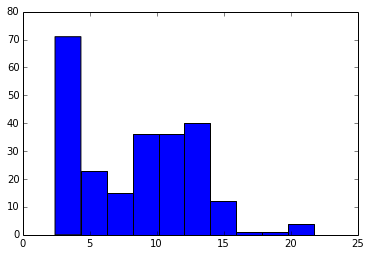

In [93]:
plt.hist(cdf.flog_score)

In [94]:
cdf2 = cdf.sort(columns = "flog_score")

In [33]:
cdf3 = cdf2.drop_duplicates(subset="student_id")


NameError: name 'cdf2' is not defined

In [96]:
o = 1
print cdf3.iloc[o].code, cdf3.iloc[o].flog_score

def num_common_letters(goal_word, guess):
	return len(set(goal_word) & set(guess)) 2.41


In [97]:
cdf3

,student_id,timestamp,time_taken,flog_score,code,sid,type
control_1114013_1447540598_291_2.41.py,1114013,1447540598,291,2.41,"def num_common_letters(goal_word, guess):\n\tr...",67,control
control_1114018_1447545535_7_2.41.py,1114018,1447545535,7,2.41,"def num_common_letters(goal_word, guess):\n\tr...",55,control
control_111712_1447799453_409_2.41.py,111712,1447799453,409,2.41,"def num_common_letters(goal_word, guess):\n\tr...",71,control
control_111902_1447990994_29_3.0.py,111902,1447990994,29,3.00,"def num_common_letters(goal_word, guess):\n\tr...",79,control
control_120723_1449536516_19_3.0.py,120723,1449536516,19,3.00,"def num_common_letters(goal_word, guess):\n\tr...",61,control
control_120712_1449531512_113_2.61.py,120712,1449531512,113,3.29,"def num_common_letters(goal_word, guess):\n\tr...",51,control
control_120722_1449535877_103_2.61.py,120722,1449535877,103,3.29,"def num_common_letters(goal_word, guess):\n ...",54,control
control_120713_1449531544_24_3.71.py,120713,1449531544,24,4.22,"def num_common_letters(goal_word, guess):\n ...",65,control
control_120102_1449528822_18_4.1.py,120102,1449528822,18,5.73,"def num_common_letters(goal_word, guess):\n\tc...",66,control
control_120802_1449613833_121_6.87.py,120802,1449613833,121,6.87,"def num_common_letters(goal_word, guess):\n\tc...",69,control


(array([ 114.,   27.,   32.,   42.,   15.,    3.,    3.,    3.,    1.,    3.]),
 array([  2.41 ,   4.554,   6.698,   8.842,  10.986,  13.13 ,  15.274,
         17.418,  19.562,  21.706,  23.85 ]),
 <a list of 10 Patch objects>)

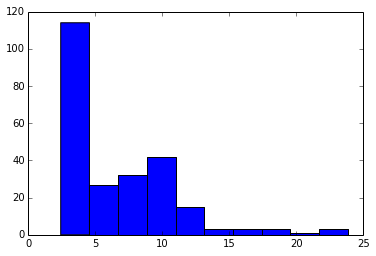

In [98]:
plt.hist(adf.flog_score)

In [99]:
adf2 = adf.sort(columns = "flog_score")

In [100]:
adf3 = adf2.drop_duplicates(subset="student_id")

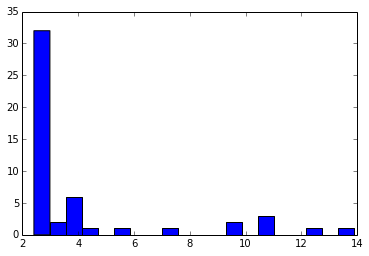

(array([ 5.,  2.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  3.,  4.,
         3.,  3.,  0.,  1.,  1.,  1.,  1.]),
 array([  2.41 ,   3.007,   3.604,   4.201,   4.798,   5.395,   5.992,
          6.589,   7.186,   7.783,   8.38 ,   8.977,   9.574,  10.171,
         10.768,  11.365,  11.962,  12.559,  13.156,  13.753,  14.35 ]),
 <a list of 20 Patch objects>)

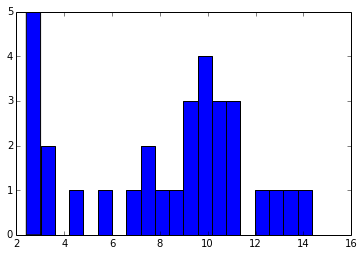

In [101]:
plt.hist(adf3.flog_score, bins=20)
plt.show()
plt.hist(cdf3.flog_score, bins=20)

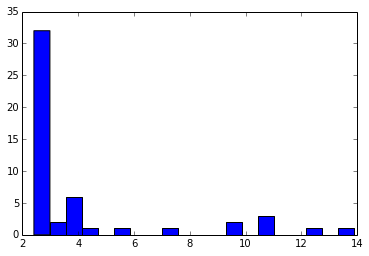

(array([ 5.,  2.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  3.,  4.,
         3.,  3.,  0.,  1.,  1.,  1.,  1.]),
 array([  2.41 ,   3.007,   3.604,   4.201,   4.798,   5.395,   5.992,
          6.589,   7.186,   7.783,   8.38 ,   8.977,   9.574,  10.171,
         10.768,  11.365,  11.962,  12.559,  13.156,  13.753,  14.35 ]),
 <a list of 20 Patch objects>)

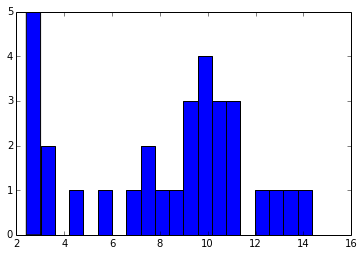

In [102]:
plt.hist(adf3.flog_score, bins=20)
plt.show()
plt.hist(cdf3.flog_score, bins=20)